Importing all the necessary libraries

In [12]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Method that applies inverse transformation on the points on the shape

In [13]:
def apply_Tinv(x, psi):
    x = x.T.reshape(2, 1)
    R = psi[:4].reshape(2, 2)
    t = psi[-2:].reshape(2, 1)
    return np.dot(np.linalg.inv(R), (x - t))

Method to calculate the affine transformation psi

In [14]:
def get_transformation(landmarks, points):
    '''
    Try to find an affine transformation matrix that maps landmarks to the image_points
    :param landmarks: initial guess of the shape
    :param points: corresponding points on the shape
    :return:
    '''
    dim = landmarks.shape[0]
    I = np.vstack([np.diag([1., 1.])] * dim)
    xn = np.column_stack([points.T[0], points.T[1]]).flatten()
    first = np.zeros((landmarks.shape[0] * 2, landmarks.shape[1]))
    first[::2] = np.fliplr(landmarks)
    second = np.vstack([[0., 0.], first])[:-1]
    points = np.hstack([first, second, I])
    psi = np.dot(np.linalg.pinv(points), xn)
    correspondence = np.reshape(points @ psi, (int(xn.shape[0] / 2), 2))
    new_landmarks = np.column_stack([correspondence.T[0], correspondence.T[1]]).astype(int)
    return psi, new_landmarks

ICP to map the model shape to the test shape

In [15]:
def run_ICP(landmarks, points, generate_plot=True):
    '''
    Try to map the W to the closest point on the edge of the shape
    :param generate_plot: Boolean flag for plotting
    :return: the final landmark points closest to the shape
    '''
    delta = False
    prev_psi = None
    iterations = 0
    wn_old = landmarks
    new_landmarks = None
    while not delta:
        psi, wn_new = get_transformation(wn_old, points.astype('int'))
        iterations += 1
        wn_old = wn_new.astype('int')
        if prev_psi is not None:
            delta = np.array_equal(psi, prev_psi)
        prev_psi = psi
    return prev_psi, wn_old

Data manipulation necessary for calculation

In [16]:
def get_landmark_points(points):
    '''
    :param points: Vector of points in the form x1, x2, ..., xn, y1, y2, ...yn
    :return: matrix of points of form (x1, y1), (x2, y2), ..., (xn, yn)
    '''
    x = points[:int(points.shape[0] / 2)]
    y = points[int(points.shape[0] / 2):]
    return np.column_stack([y, x])

Defining a function the performs PCA on the centered data. First we do a singular value decomposition to find the eigen values and eigen vectors. We are required to use 90% of the total energy. So we set threshold at 0.1 and if for some K, the ratio of sum of K eigen values to sum of all eigen values exceeds 1-threshold, we take those K eigen values as the principal components of the data.

In [17]:
def pca(centered_data, threshold=0.1):
    '''
    return eigen values, eigen vectors and No of PCA
    :param centered_data:
    :param threshold:
    :return: eigen values, eigen vectors and No of PCA
    '''
    wwt = centered_data @ centered_data.T
    U, L2, Vt = np.linalg.svd(wwt)
    L2_ratio = np.cumsum(L2) / np.sum(L2)
    compared = L2_ratio[L2_ratio <= 1 - threshold]
    return U, L2, compared.size

The following is just the plotting function for the shape. Each shape is 
arranged as a column arranged as [x_0 x_1 ... x_55 y_0 y_1 y_55]^T. So we rearrange the data in x and y co-ordinate list before plotting.

In [18]:
def plot_shape(points, title):
    '''
    plots the shape
    :param points: points on the shape
    :param title: Title of the plot
    :return:
    '''
    fig = plt.figure(figsize=(16, 8))
    x = points[:int(points.shape[0] / 2)]
    y = points[int(points.shape[0] / 2):]
    plt.plot(x, y, '-o', color='red', zorder=2)
    plt.title(title)
    plt.show()

The solution for task 2 has following steps:


1.   We read the data from hands_aligned_train.txt.new into a numpy matrix. The first row is skipped as it contains the information of number of columns and number of rows.
2.   Next Calculate the mean shape and plot it
3.   We subtract the mean shape from each shape to normalise so that every column of the data has a mean of zero. Then on this zero mean data, we perform PCA and define LK (diagonal matrix of size K x K) and UK (truncated eigen vectors) for further calculations.
4.   Next we estimate K shapes using the weights and rolling the values to visualise effect of weights on each phi_k. We just plot oly certain permutations of weights.





In [19]:
def task_2():
    '''
    Solution for task 2
    :return:
    '''
    training_data = np.loadtxt('data/hands_aligned_train.txt.new', skiprows=1)
    weights = np.array([(-0.4, -0.2, 0.0, 0.2, 0.4)])
    mu = np.mean(training_data, axis=1)
    plot_shape(mu, 'Mean Shape')
    centered_data = training_data - mu.reshape(112, 1)
    U, L2, K = pca(centered_data)
    LK = np.diag(L2[:K])
    UK = U[:, :K]
    variance_hat = np.sum(L2[K:]) / (L2.shape[0] - K)
    I = np.eye(LK.shape[0])
    phi_hat = UK @ np.sqrt(np.subtract(LK, variance_hat * I))
    prev_weights = weights
    for i in range(K):
        weights_str = ",".join(map(str, prev_weights.tolist()))
        hphi = phi_hat @ prev_weights.T
        w = mu + np.sum(hphi, axis=0)
        plot_shape(w, 'K = {}, weights = {}'.format(i + 1, weights_str))
        prev_weights = np.roll(prev_weights, 1)
    return mu, variance_hat, phi_hat

The solution for task 3 has following steps:


1.   Get the Model parameters, mean shape and phi from task 02
2.   Read testing data in a numpy array
3.   Try to estimate h that reconstructs the test shape from the model
4.   At each step we try to find an affine transformation, psi, that maps the current landmarks to the test shape. Then we project onto the model co-ordinates using psi inverse
5.   We update h accordingly and check for convergence. If not converged, then repeat the process.



In [20]:
def task_3(mean_shape, phi):
    b = None
    hphi = None
    delta = False
    test_data = np.loadtxt('data/hands_aligned_test.txt.new', skiprows=1)
    iterations = 0
    current_landmark = get_landmark_points(mean_shape)
    b_old = None
    points = get_landmark_points(test_data)
    y = points
    while not delta:
        psi, current_landmark = run_ICP(current_landmark, y, generate_plot=False)
        y = np.apply_along_axis(apply_Tinv, 1, points, psi)
        y = y.reshape(y.shape[0], y.shape[1])
        b = phi.T @ np.subtract(y.flatten('F'), mean_shape)
        if b_old is not None:
            delta = np.array_equal(b, b_old)
        hphi = np.dot(phi, np.diag(b))
        current_landmark = mean_shape + np.sum(hphi)
        plot_shape(current_landmark.astype('int'), 'Iteration: {}'.format(iterations+1))
        current_landmark = get_landmark_points(current_landmark)
        iterations += 1
        b_old = b

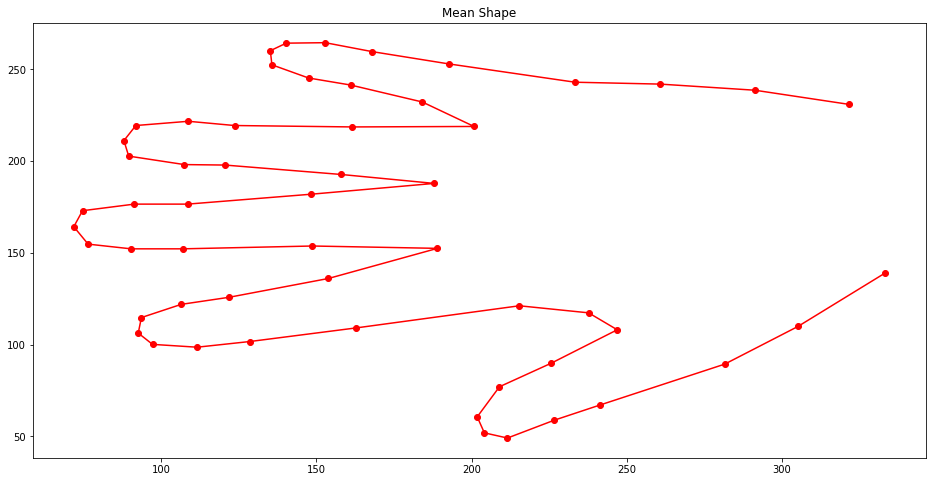

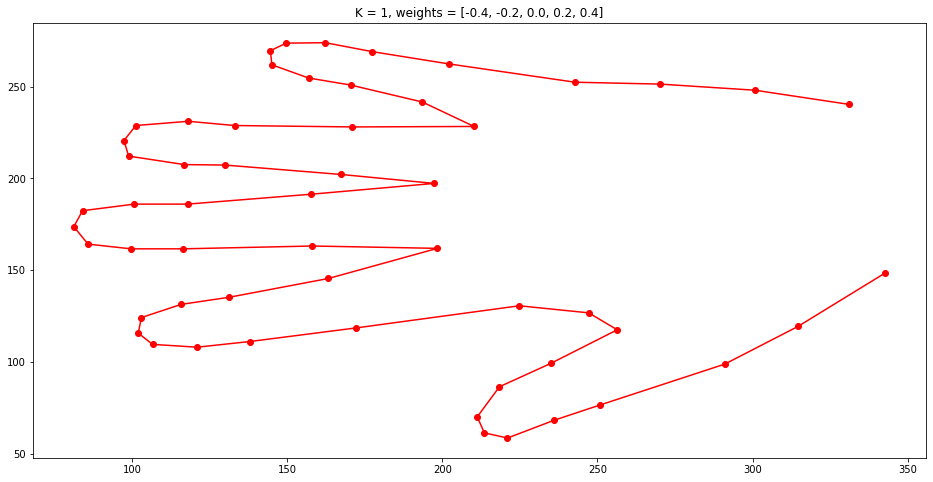

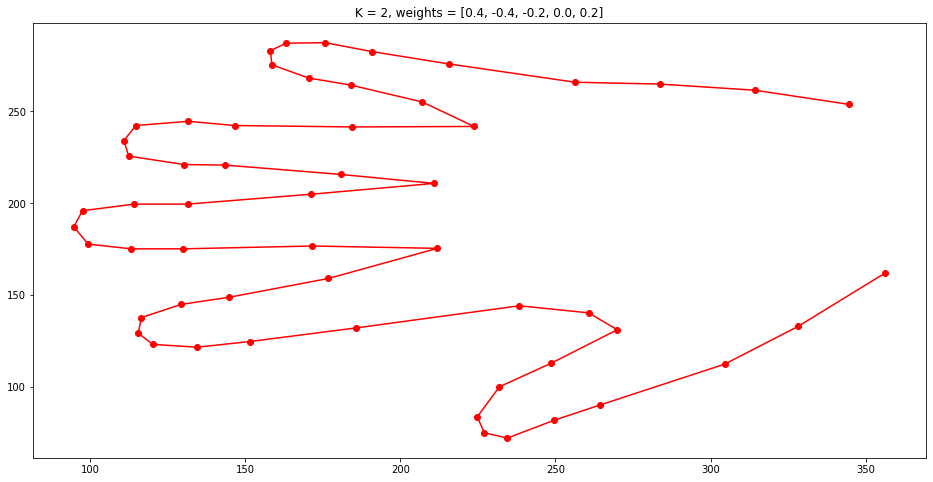

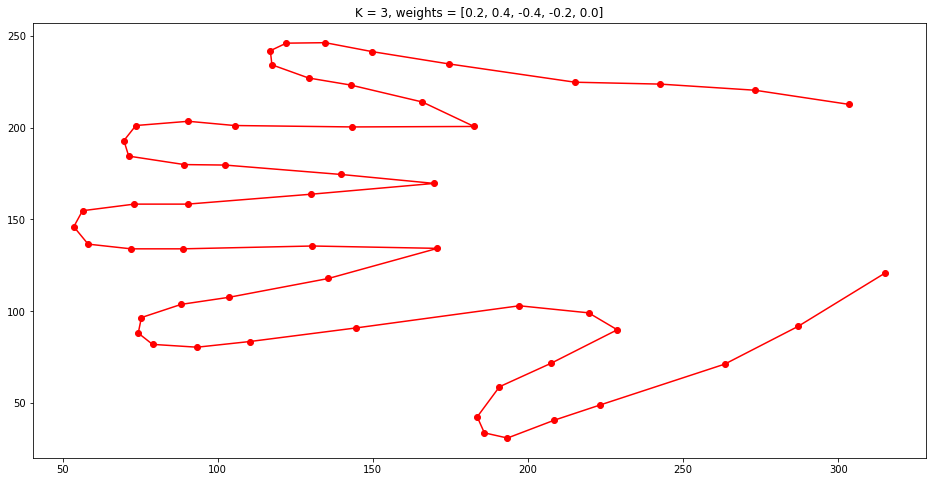

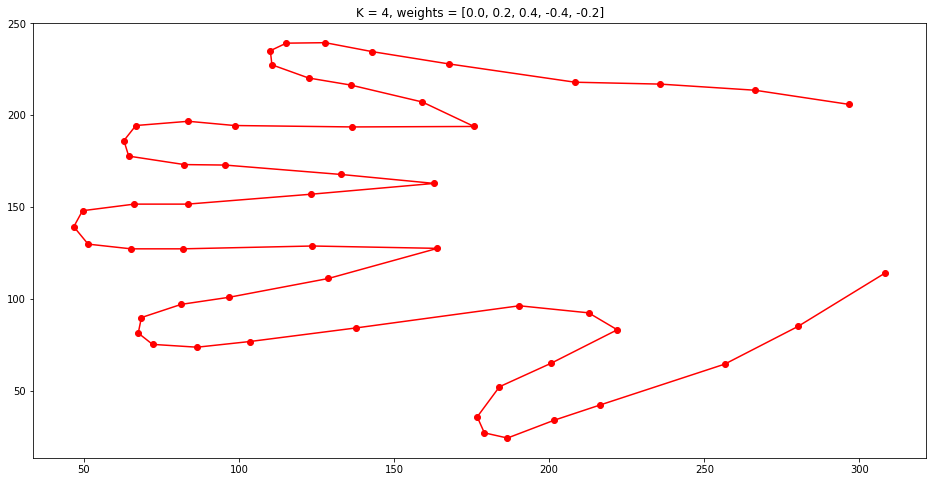

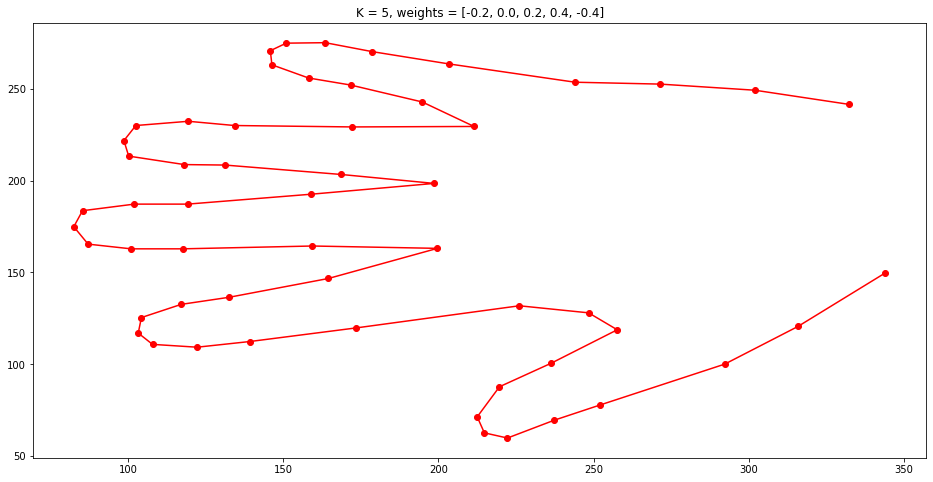

In [21]:
mean_shape, sigma_sqr, phi = task_2()


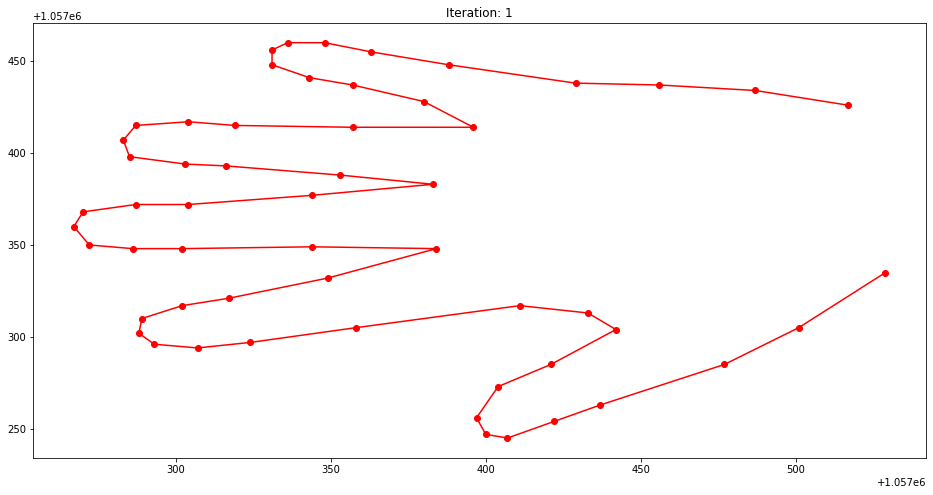

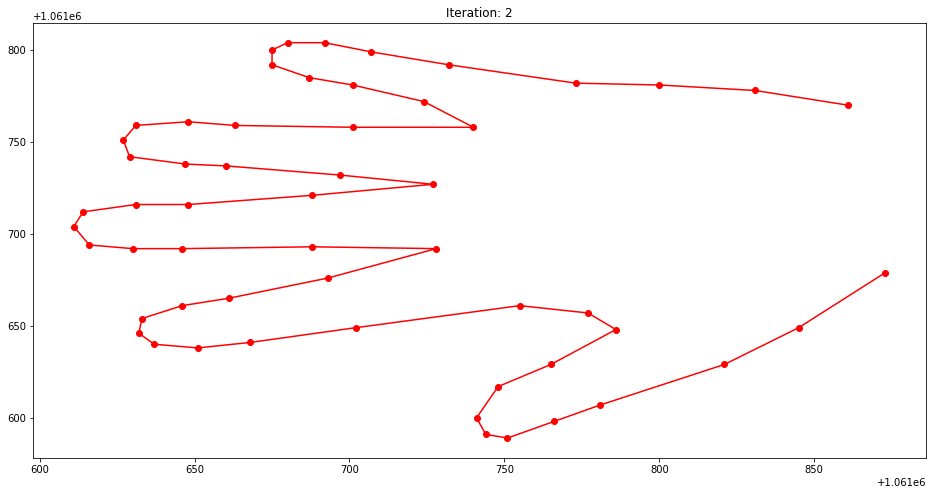

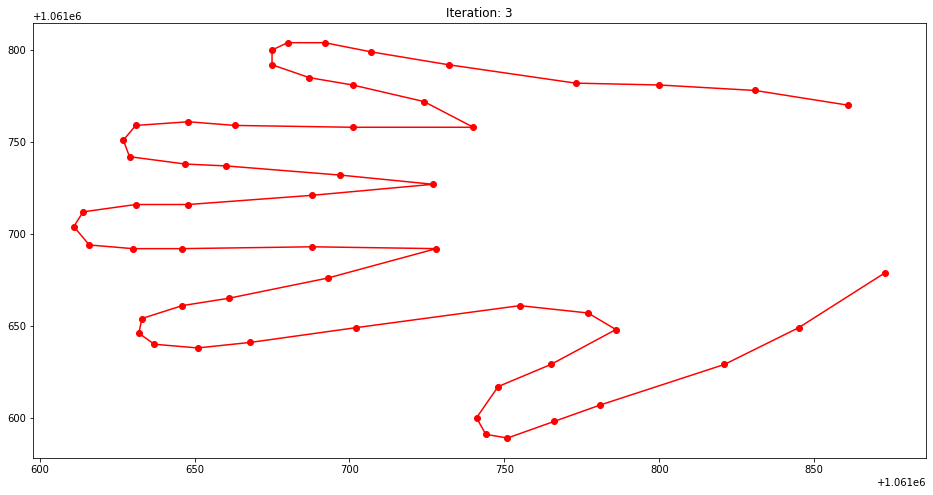

In [22]:
final_shape = task_3(mean_shape.astype('int'), phi)